In [1]:
import sys
sys.argv = ['']

In [2]:
#from diffuser.utils.arrays import to_torch, to_np, to_device
#from diffuser.datasets.d4rl import suppress_output
#from scripts.buffer_utils import LoadSequenceDataset
#from scripts.buffer_utils import OptimalBuffer
from scripts.mopo.utils_trans import RewardPredictingModel 
#from scripts.buffer_utils import augment_trajectories_new
import diffuser.utils as utils

/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import shutil 
import argparse 
import time 
import pickle
import sys
import os
import torch
import random
import importlib
from collections import defaultdict
import pdb
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from time import time

In [5]:
from collections import defaultdict

In [6]:
from sklearn.cluster import KMeans

In [7]:
import d4rl

No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11


In [8]:
def import_config(config_name):
    module_path = f"detail_configs.{config_name}"
    try:
        module = importlib.import_module(module_path)
        return module.Config    
    except ImportError:
        print(f"Error: Module '{config_name}' not found or has no 'Config' attribute.")
        return None

In [9]:
from ml_logger import logger

Config = import_config('kitchen_partial_task')

Config.dataset = 'kitchen-partial-v0'

In [ ]:
# log path
BASE_WEIGHTS_PATH = os.path.join(Config.bucket, Config.dataset)
save_config_path = os.path.join(BASE_WEIGHTS_PATH, "config")
logger.configure(save_config_path)
torch.backends.cudnn.benchmark = True

# training dataset for Diffuser
dataset_config = utils.Config(
		'datasets.CondSequenceDataset',
		savepath='dataset_config.pkl',
		env=Config.dataset,
		horizon=Config.horizon,
		normalizer=Config.normalizer,
		preprocess_fns=Config.preprocess_fns,
		use_padding=Config.use_padding,
		max_path_length=Config.max_path_length,
		include_returns=Config.include_returns,
		returns_scale=Config.returns_scale,
        data_file=Config.data_file,
	)
render_config = utils.Config(
        Config.renderer,
        savepath="render_config.pkl",
        env=Config.dataset,
    )

dataset = dataset_config()
renderer = None
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
loadpath = os.path.join(Config.bucket, Config.dataset, Config.prefix, 'checkpoint')
print('\n\nloadpath = ', loadpath, end = '\n\n')



# model configs
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
transition_dim = observation_dim

model_config = utils.Config(
		Config.model,
		savepath='model_config.pkl',
		horizon=Config.horizon,
		transition_dim=transition_dim,
		cond_dim=observation_dim,
		dim_mults=Config.dim_mults,
		dim=Config.dim,
		returns_condition=Config.returns_condition,
		device=Config.device,
	)

diffusion_config = utils.Config(
    Config.diffusion,
    savepath='diffusion_config.pkl',
    horizon=Config.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=Config.n_diffusion_steps,
    loss_type=Config.loss_type,
    clip_denoised=Config.clip_denoised,
    predict_epsilon=Config.predict_epsilon,
    hidden_dim=Config.hidden_dim,
    ## loss weighting
    action_weight=Config.action_weight,
    loss_weights=Config.loss_weights,
    loss_discount=Config.loss_discount,
    returns_condition=Config.returns_condition,
    device=Config.device,
    condition_guidance_w=Config.condition_guidance_w,
)

trainer_config = utils.Config(
		utils.Trainer,
		savepath='trainer_config.pkl',
		train_batch_size=Config.batch_size,
		train_lr=Config.learning_rate,
		gradient_accumulate_every=Config.gradient_accumulate_every,
		ema_decay=Config.ema_decay,
		sample_freq=Config.sample_freq,
		save_freq=Config.save_freq,
		log_freq=Config.log_freq,
		label_freq=int(Config.n_train_steps // Config.n_saves),
		save_parallel=Config.save_parallel,
		bucket=Config.bucket,
		n_reference=Config.n_reference,
        n_samples=Config.n_samples,
		train_device=Config.device,
	)
model = model_config()
diffusion = diffusion_config(model)
trainer = trainer_config(diffusion, dataset, renderer)

# load Diffuser model
loadpath = os.path.join(loadpath, f'state_1000000.pt')
state_dict = torch.load(loadpath, map_location=Config.device)
trainer.step = state_dict['step']
trainer.model.load_state_dict(state_dict['model'])
trainer.ema_model.load_state_dict(state_dict['ema'])

# load Dynamic model
Config.dynamic_model_path = '/common/users/cc1547/projects/rainbow/diffstitch/dynamic/kitchen-partial-v0/mopo/' \
'seed_1_0807_170549-kitchen_partial_v0_mopo/models/ite_dynamics_model'
dynamics_model = RewardPredictingModel(
    device = Config.device, 
    env_name = Config.dataset, 
    load_path = Config.dynamic_model_path
) 

✓ created a new logging client
Dashboard: http://app.dash.ml/common/users/cc1547/projects/rainbow/diffstitch/diffuser/kitchen-partial-v0/config
Log_directory: /common/home/cc1547/projects/diff_stitch
[ utils/config ] Imported diffuser.datasets:CondSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CondSequenceDataset'>
    data_file: None
    env: kitchen-partial-v0
    horizon: 40
    include_returns: True
    max_path_length: 280
    normalizer: CDFNormalizer
    preprocess_fns: []
    returns_scale: 1.0
    use_padding: True

[ utils/config ] Saved config to: dataset_config.pkl

[ utils/config ] Imported diffuser.utils:MuJoCoRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.MuJoCoRenderer'>
    env: kitchen-partial-v0

[ utils/config ] Saved config to: render_config.pkl

class =  <class 'diffuser.datasets.sequence.CondSequenceDataset'>
kwargs =  {}


No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.77it/s]


[ datasets/buffer ] Finalized replay buffer | 613 episodes
[ datasets/buffer ] Fields:
    observations: (613, 280, 30)
    rewards: (613, 280, 1)
    actions: (613, 280, 9)
    terminals: (613, 280, 1)
    normed_observations: (613, 280, 30)
    normed_actions: (613, 280, 9)


loadpath =  /common/users/cc1547/projects/rainbow/diffstitch/diffuser/kitchen-partial-v0/default_inv/predict_epsilon_100_1000000.0/dropout_0.25/kitchen_partial/task/40/checkpoint

[ utils/config ] Imported diffuser.models:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 30
    dim: 128
    dim_mults: (1, 4, 8)
    horizon: 40
    returns_condition: True
    transition_dim: 30

[ utils/config ] Saved config to: model_config.pkl

[ utils/config ] Imported diffuser.models:GaussianInvDynDiffusion

[utils/config ] Config: <class 'diffuser.models.diffusion.GaussianInvDynDiffusion'>
    action_dim: 9
    action_weight: 10
    clip_denoised: True
    condition_guidance_

In [10]:
def to_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x


def to_torch(x, dtype=None, device=None):
    dtype = dtype or DTYPE
    device = device or DEVICE
    if type(x) is dict:
        return {k: to_torch(v, dtype, device) for k, v in x.items()}
    elif torch.is_tensor(x):
        return x.to(device).type(dtype)
        # import pdb; pdb.set_trace()
    return torch.tensor(x, dtype=dtype, device=device)


def to_device(x, device=Config.device):
    if torch.is_tensor(x):
        return x.to(device)
    elif type(x) is dict:
        return {k: to_device(v, device) for k, v in x.items()}
    else:
        print(f"Unrecognized type in `to_device`: {type(x)}")
        pdb.set_trace()
    # return [x.to(device) for x in xs]

In [11]:
def process_kitchen_episode(episode):
    rewards_ = episode["rew"][1:] - episode["rew"][:-1]
    rewards = np.concatenate([episode["rew"][:1], rewards_], axis=0)
    episode["rew"] = rewards

    obs = episode["obs"]
    episode["obs"] = obs[:, :30]  # remove the goal
    next_obs = episode["next_obs"]
    episode['next_obs'] = next_obs[:, :30]
    return episode

def task_dataset(seq_dataset):

    tasks = []

    task_data = defaultdict(list)
    rewards = seq_dataset["rew"]

    l = rewards.shape[0]
    for i in range(l):

        for k in seq_dataset:
            task_data[k].append(seq_dataset[k][i])

        if rewards[i] == 1:
            for k in task_data:
                task_data[k] = np.array(task_data[k])
            tasks.append(task_data)
            task_data = defaultdict(list)

    '''
    if len(task_data) > 0:
        for k in task_data:
            task_data[k] = np.array(task_data[k])
        tasks.append(task_data)
    '''
    return tasks

In [12]:
def load_data(data_file):
    with open(data_file, "rb") as fp:
        ds = pickle.load(fp)
    return ds
    
class LoadSequenceDataset:
    def __init__(self, env_name, data_file):
        if 'kitchen' not in env_name:
            dataset = load_data(data_file)
            if "AntMaze_UMaze-v4" in env_name:
                dataset_name = "antmaze-umaze-v0"
            elif "AntMaze_Medium-v4" in env_name:
                dataset_name = "antmaze-medium-v0"
            elif "AntMaze_Large-v4" in env_name:
                dataset_name = "antmaze-large-v0"
            elif "PointMaze_UMaze-v3" in env_name:
                dataset_name = "pointmaze-umaze-v0"
            elif "PointMaze_Medium-v3" in env_name:
                dataset_name = "pointmaze-medium-v1"
            elif "PointMaze_Large-v3" in env_name:
                dataset_name = "pointmaze-large-v1"
            else:
                raise NotImplementedError
            max_path_length = 600
        else:
            env = gym.make(env_name)
            dataset = env.get_dataset()
            max_path_length = 280

        print(f"\nnumber of offline data is {dataset['rewards'].shape[0]}\n")

        paths = []
        current_path = {"obs": [], "act": [], "rew": [], "dones": [], "next_obs": []}
        
        use_timeouts = "timeouts" in dataset

        print(use_timeouts)

        for i in range(dataset["rewards"].shape[0] - 1):
            if 'kitchen' not in env_name:
                current_path["obs"].append(dataset["observations"]["observation"][i])
                current_path["dones"].append(dataset["terminations"][i])
                current_path["next_obs"].append(
                dataset["observations"]["observation"][i + 1]
            )
            else:
                current_path['obs'].append(dataset['observations'][i])
                current_path["dones"].append(dataset["terminals"][i])
                current_path["next_obs"].append(
                dataset["observations"][i + 1]
            )
                
            current_path["act"].append(dataset["actions"][i])
            current_path["rew"].append(dataset["rewards"][i])
            
            

            if use_timeouts:
                final_timestep = dataset["timeouts"][i]
            else:
                final_timestep = len(current_path["obs"]) == max_path_length

            done = dataset['terminations'][i] if 'kitchen' not in env_name else dataset['terminals'][i]
            if bool(done) or final_timestep:
                for _ in current_path:
                    current_path[_] = np.array(current_path[_])
                if 'kitchen' in env_name:
                    current_path = process_kitchen_episode(current_path)
                    task_path = task_dataset(current_path)
                    paths.extend(task_path)
                else:
                    paths.append(current_path)
                current_path = {
                    "obs": [],
                    "act": [],
                    "rew": [],
                    "dones": [],
                    "next_obs": [],
                }
        self.paths = paths
        self.num_traj = len(self.paths)

    def get_full_info_traj(self, idx, gamma=0.99):
        obs = []
        act = []
        rew = []
        next_obs = []
        dones = []
        region_idx = []
        obs = np.copy(self.paths[idx]["obs"])
        act = np.copy(self.paths[idx]["act"])
        rew = np.copy(self.paths[idx]["rew"])
        next_obs = np.copy(self.paths[idx]["next_obs"])
        dones = np.copy(self.paths[idx]["dones"])

        total_return = np.sum(rew)
        discounted_return = 0
        for i in range(rew.shape[0] - 1, -1, -1):
            discounted_return = discounted_return * gamma + rew[i]
        return {
            "obs": obs,
            "act": act,
            "rew": rew,
            "next_obs": next_obs,
            "dones": dones,
            "total_return": total_return,
            "discounted_return": discounted_return,
            "horizon": rew.shape[0],
            "trajectory_idx": idx,
        }

In [13]:
class OptimalBuffer:
    def __init__(self, horizon, ratio=0.1, gamma=0.99):
        self.gamma = gamma
        self.ratio = ratio
        self.info = []
        self.horizon = horizon
        self.region_map = defaultdict(list)
        self.returns_list = []

    def insert_traj(self, info):
        current_total_reward = 0
        current_discounted_reward = 0
        for i in range(info["horizon"] - 1, -1, -1):
            current_total_reward += info["rew"][i]
            current_discounted_reward = (
                current_discounted_reward * self.gamma + info["rew"][i]
            )
            if info["horizon"] - i >= self.horizon:
                current_info = {
                    "discounted_reward": current_discounted_reward,
                    "obs": info["obs"][i : i + self.horizon],
                    "segment_idx": i,
                    "traj_idx": info["trajectory_idx"],
                    'rew': info['rew'][i: i+self.horizon],
                }
                self.info.append(current_info)
    
    def finalize(self, ):
        num_seg = len(self.info)
        all_obs = np.array([info['obs'] for info in self.info]).mean(axis=-1)
        kmeans = KMeans(n_clusters=10, n_init='auto').fit(all_obs)
        labels = kmeans.labels_
        for i in range(num_seg):
            self.info[i]['region_idx'] = np.ones(self.horizon,dtype=np.int32) * labels[i]
            self.region_map[labels[i]+1].append(i)
            self.returns_list.append(sum(self.info[i]['rew']))
        self.returns_list = np.array(self.returns_list)
        self.returns_list -= self.returns_list.min()

    def sample_batch_traj(self, optim_batch, dataset, region_avoid):
        # stored in (d-rtg, obs:(100, obs_dim))

        sample_idx = []
        
        for k in self.region_map:
            if k not in region_avoid:
                sample_idx += self.region_map[k]

        sample_p = self.returns_list[np.array(sample_idx)]
        sample_p = sample_p / sample_p.sum()
        batch_info = []
        batch_index = np.random.choice(sample_idx, size=optim_batch, replace=False, p=sample_p)
        batch_info = [self.info[_] for _ in batch_index]

        return batch_info

In [14]:
# prepare dataset for stitching
env_name = Config.dataset
if 'kitchen' in env_name:
    data_file = None
else:
    if "AntMaze_UMaze-v4" in env_name:
        dataset_name = "antmaze-umaze-v0"
    elif "AntMaze_Medium-v4" in env_name:
        dataset_name = "antmaze-medium-v0"
    elif "AntMaze_Large-v4" in env_name:
        dataset_name = "antmaze-large-v0"
    elif "PointMaze_UMaze-v3" in env_name:
        dataset_name = "pointmaze-umaze-v1"
    elif "PointMaze_Medium-v3" in env_name:
        dataset_name = "pointmaze-medium-v1"
    elif "PointMaze_Large-v3" in env_name:
        dataset_name = "pointmaze-large-v1"
    
    dataset_name = dataset_name + ".pkl"
    data_file = Config.data_file + dataset_name
env_dataset = LoadSequenceDataset(env_name = Config.dataset, data_file=data_file)
data_buffer  = OptimalBuffer(horizon=Config.horizon)
for i in range(env_dataset.num_traj): 
    info = env_dataset.get_full_info_traj(i)  
    data_buffer.insert_traj(info) 
data_buffer.finalize()

Reading configurations for Franka
Initializing Franka sim


/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.01it/s]



number of offline data is 136950

True


## Start stitching

In [15]:
# helper functions
#def cosine_similarity(x, y):
#    x_norm = np.linalg.norm(x)
#    y_norm = np.linalg.norm(y, axis=1)
#    dot_product = np.dot(y, x)
#    similarity = dot_product / (x_norm * y_norm)
#    return similarity

def cosine_similarity(x, y):
    x_norm = np.linalg.norm(x, axis=1, keepdims=True)
    y_norm = np.linalg.norm(y, axis=1, keepdims=True)
    similarity = np.dot(x/x_norm, (y/y_norm).transpose())
    return similarity

def comp_distance(x, y):
    return np.linalg.norm(x-y, axis=-1)

def cell_xy_to_rowcol(maze, xy_pos: np.ndarray) -> np.ndarray:
    """Converts a cell x and y coordinates to `(i,j)`"""

    i = np.reshape((maze.y_map_center - xy_pos[:, 1]) / maze.maze_size_scaling, (-1, 1))
    j = np.reshape((xy_pos[:, 0] + maze.x_map_center) / maze.maze_size_scaling, (-1, 1))

    return np.concatenate([i,j], axis=-1)

In [16]:
class Timer:
    def __init__(self):
        self.total_clapsed = 0
        self.start = time()
        self.call_time = 0

    def __call__(self):
        
        clapsed = time() - self.start
        self.call_time += 1
        
        self.total_clapsed += clapsed
        self.start = time()
        return self.total_clapsed

    def mean(self,):
        
        clapsed = time() - self.start
        self.call_time += 1
        
        self.total_clapsed += clapsed
        self.start = time()
        return self.total_clapsed / self.call_time
        

In [17]:
def get_conditions(conditions, start, x, device):

    obs_dim = x.shape[-1]
    
    conditions[:, :, obs_dim:] = 0
    conditions[:, :start, :obs_dim] = 0
    conditions[:, :start, obs_dim:] = x[:, -start:, :]
    conditions = torch.tensor(conditions).to(device)
    
    return conditions

In [18]:
horizon = Config.horizon
device = Config.device
dynamics_deviate = 0.15
test_ret = 0.85
sample_optim_batch = 1000
dreamer_similarity = 0.95
stitch_L = 10
stitch_R = 30
#obs_dim = observation_dim
dream_len = Config.dream_len
stitch_batch_size = 1000

In [99]:
aug_list = []

timer = Timer()
timer_2 = Timer()
generated_transitions = 0
while generated_transitions < 10000:
    

    trj1_info = data_buffer.sample_batch_traj(stitch_batch_size, env_dataset, [])
    
    trj1_obs = np.stack([info['obs'] for info in trj1_info], axis=0)
    trj1_normed_obs = dataset.normalizer.normalize(trj1_obs, 'observations')

    # conditional generation from the end of trj1
    cond = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    conditions = get_conditions(cond, dream_len, trj1_normed_obs, device)
    returns = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)

    samples = trainer.ema_model.conditional_sample(
        conditions, returns=returns, verbose=False
    )  # shape is [N, 100, 11]
    normed_gen_obs = to_np(samples)
    gen_obs = dataset.normalizer.unnormalize(normed_gen_obs, 'observations')

    # 
    cond_p = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    mark_succ = np.zeros(shape=(stitch_batch_size,))
    positions = []
    for i in range(0, stitch_batch_size):
        region_idx1 = trj1_info[i]['region_idx'][0]
        
        # sample a batch of optimal trajectories
        available_positions = []
        n_try = 0
        while len(available_positions) == 0:
            candidates_trj2_info = data_buffer.sample_batch_traj(
                sample_optim_batch, dataset, [region_idx1]
            )
            
            candidates_trj2_obs = np.stack([info['obs'] for info in candidates_trj2_info], axis=0)
            region_idx2 = np.array([info['region_idx'][0] for info in candidates_trj2_info])
            
            # (stitch_L - stitch_R) x sample_optim_batch
            cosin_sim = cosine_similarity(gen_obs[i, stitch_L:stitch_R], candidates_trj2_obs[:, 0])
            # see which trajectory has a similarity greater than threshold
            for cur_pos in range(stitch_L, stitch_R):
                
                cur_sim = cosin_sim[cur_pos-stitch_L]
            
                if np.max(cur_sim) < dreamer_similarity:
                    continue
                temp_pos = list(np.where(cur_sim >= dreamer_similarity)[0])
                for pos in temp_pos:
                    available_positions.append(pos)
            n_try += 1
            if n_try >  3:
                break

        
        if len(available_positions) == 0:
            # pdb.set_trace()
            positions.append([0, 0])
            continue
            
        available_positions = list(set(available_positions))
        
        mark_succ[i] = 1
        chosen_index = random.randint(0, len(available_positions) - 1)

        trj2_info = candidates_trj2_info[available_positions[chosen_index]]
        
        traj2_obs = trj2_info["obs"]
        traj2_normed_obs = dataset.normalizer.normalize(traj2_obs, "observations")
        traj2_idx = candidates_trj2_info[available_positions[chosen_index]]['traj_idx']
        traj2_start_idx = candidates_trj2_info[available_positions[chosen_index]]['segment_idx']
        region_idx2 = candidates_trj2_info[available_positions[chosen_index]]['region_idx'][0]
        
        # (stitch_L - stitch_R) x 1
        sim_i = cosin_sim[:,available_positions[chosen_index]]
        best_pos = np.argmax(sim_i, axis=0) + stitch_L
        
        start_index = dream_len
        end_index = best_pos - 1
        positions.append([start_index, end_index, traj2_idx, traj2_start_idx, region_idx1, region_idx2])
        cond_p[i][:, obs_dim:] = 0
        cond_p[i][:start_index, :obs_dim] = 0
        cond_p[i][:start_index, obs_dim:] = trj1_normed_obs[i][-start_index:]
        cond_p[i][end_index + 1 :, :obs_dim] = 0
        cond_p[i][end_index + 1 :, obs_dim:] = traj2_normed_obs[: horizon - best_pos]

    conditions_p = torch.tensor(cond_p).to(device)
    returns_p = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    samples_p = trainer.ema_model.conditional_sample(
        conditions_p, returns=returns_p, verbose=False
    )  # shape is [64, 100, 11]
    np_samples_p = to_np(samples_p)
    obss_p = dataset.normalizer.unnormalize(np_samples_p, "observations")
    
    traj2_time = timer_2.mean()
    print(f'traj2 preparation time: {traj2_time:.2f}')
    
    
    succ_cnt = 0
    
    print(f' number of candidate trj1: {sum(mark_succ)}')
    if sum(mark_succ) == 0:
        print(f'no trj2 found')
        continue
    # pdb.set_trace()
        
    
    total_number_traj = sum(mark_succ)
    filtered_number_traj = 0
    
    for j in range(0, stitch_batch_size):
    
        # failed to reach threshold
        if mark_succ[j] != 1:
            print(f'{j}th sample no stitching')
            continue
        end_index = positions[j][1]
        start_index = positions[j][0]
        traj2_idx = positions[j][2]
        traj2_start_idx = positions[j][3]
        region_idx1 = positions[j][4]
        region_idx2 = positions[j][5]

        move = np.linalg.norm(obss_p[j][:-1,:2] - obss_p[j][1:,:2], axis=-1)
        if (move > dynamics_deviate).any():
            jump = move.max()
            filtered_number_traj += 1
            print(f'found jumps {jump:.3f} in {j}th stitching')
            continue
        
        best_pos = end_index + 1
        len_path_data = end_index - start_index + 2
        return_info = {}
        return_info["act"] = np.zeros(shape=(len_path_data, action_dim))
        return_info["rew"] = np.zeros(shape=(len_path_data))
        return_info["obs"] = np.zeros(shape=(len_path_data + 1, obs_dim))
        

        obs_comb = torch.cat(
                [samples_p[j, start_index - 1:end_index+1, :], samples_p[j, start_index:end_index+2, :]], dim=-1
            )
        obs_comb = obs_comb.reshape(-1, 2 * obs_dim)
        action_ = trainer.ema_model.inv_model(obs_comb)  # [1,3]
        normed_actions = to_np(action_)
        actions = dataset.normalizer.unnormalize(normed_actions, 'actions')
        
        dynamics_info = dynamics_model.predict(
            obss_p[j, start_index-1:end_index+1], actions
        )
        pred_obs = dynamics_info['next_obs']
        pred_rew = dynamics_info['reward']

        normed_pred_obs = dataset.normalizer.normalize(pred_obs, "observations")
        pred_deviate = np.linalg.norm(pred_obs - obss_p[j, start_index:end_index+2], axis=-1)
        if (pred_deviate > dynamics_deviate).any():
            filtered_number_traj += 1
            deviate = pred_deviate.max()
            print(f'dynamics: {j}th filtered deviate {deviate:.3f}')
            continue

        succ_cnt += 1
        return_info["obs"] = obss_p[j][start_index - 1 : end_index + 2]
    
        aug_cnt = return_info["rew"].shape[0]
    
        return_info["next_obs"] = return_info["obs"][1:]
        return_info["obs"] = return_info["obs"][:-1]
        return_info["dones"] = np.full((aug_cnt,), False, dtype=bool)
        return_info['region_idx'] = np.ones((aug_cnt,), dtype=np.int8) * int(str(region_idx1)+str(region_idx2))
    
        for _ in ["obs", "rew", "dones", "next_obs", "act"]:
            return_info[_] = return_info[_][:]
    
        generated_transitions = generated_transitions + return_info["obs"].shape[0] + 2 * horizon
        if succ_cnt % 1 == 0:
            clapsed = timer() / generated_transitions * 1000
            
            print(f' =========  processed {generated_transitions} transitions,\t clapsed per 1k transition {clapsed:.2f} sec.  =========')
            
        aug_list.append(
            (
                trj1_info[j]['traj_idx'],
                trj1_info[j]['segment_idx'],
                traj2_idx,
                traj2_start_idx,
                start_index,
                end_index,
                obss_p[j],
                return_info["obs"],
                return_info["act"],
                return_info["rew"],
                return_info["next_obs"],
                return_info["dones"],
                return_info['region_idx']
            )
        )

traj2 preparation time: 39.66
 number of candidate trj1: 950.0
0th sample no stitching
dynamics: 1th filtered deviate 0.734
dynamics: 2th filtered deviate 0.812
dynamics: 3th filtered deviate 0.865
dynamics: 4th filtered deviate 0.717
found jumps 3.008 in 5th stitching
dynamics: 6th filtered deviate 0.850
 =========  processed 91 transitions,	 clapsed per 1k transition 436.17 sec.  =========
8th sample no stitching
dynamics: 9th filtered deviate 0.199
dynamics: 10th filtered deviate 0.537
dynamics: 11th filtered deviate 0.685
found jumps 0.297 in 12th stitching
found jumps 2.730 in 13th stitching
found jumps 0.220 in 14th stitching
dynamics: 15th filtered deviate 1.048
dynamics: 16th filtered deviate 1.133
found jumps 0.211 in 17th stitching
found jumps 2.911 in 18th stitching
dynamics: 19th filtered deviate 0.546
dynamics: 20th filtered deviate 0.488
dynamics: 21th filtered deviate 0.525
found jumps 0.155 in 22th stitching
dynamics: 23th filtered deviate 0.230
dynamics: 24th filtered 

### Second round stitch

In [97]:
with open('./round1_stitch_point_medium.pkl', 'rb') as f:
    stitched_data = pickle.load(f)

In [30]:
class StitchDataset:
    def __init__(self, trajectories):
        self.paths = trajectories
        self.num_traj = len(self.paths)
        print(f'processed {self.num_traj} trajectories')

    def get_full_info_traj(self, idx, gamma=0.99):
        obs = []
        act = []
        rew = []
        next_obs = []
        dones = []
        region_idx = []
        obs = np.copy(self.paths[idx]["obs"])
        act = np.copy(self.paths[idx]["act"])
        rew = np.copy(self.paths[idx]["rew"])
        next_obs = np.copy(self.paths[idx]["next_obs"])
        dones = np.copy(self.paths[idx]["dones"])
        region_idx = np.copy(self.paths[idx]["region_idx"])

        total_return = np.sum(rew)
        discounted_return = 0
        for i in range(rew.shape[0] - 1, -1, -1):
            discounted_return = discounted_return * gamma + rew[i]
        return {
            "obs": obs,
            "act": act,
            "rew": rew,
            "next_obs": next_obs,
            "dones": dones,
            "total_return": total_return,
            "discounted_return": discounted_return,
            "horizon": rew.shape[0],
            "region_idx": region_idx,
            "trajectory_idx": idx,
        }

In [29]:
def process_stitched_trajectories(origin_trj1, stitch_trj, origin_trj2):
    """ concatenate one origin_trj and the corresponding stitch_trj"""
    
    keys = ['obs', 'act', 'rew', 'next_obs', 'dones']
    new_trj = {}
    for k in keys:
        assert k in origin_trj1, f'{k} not in origin_trj1'
        assert k in origin_trj2, f'{k} not in origin_trj2'
        assert k in stitch_trj, f'{k} not in stitch_trj'
        new_trj[k] = np.concatenate([origin_trj1[k], stitch_trj[k], origin_trj2[k]], axis=0)
        
    trj_len = new_trj['obs'].shape[0]
    new_trj['region_idx'] = stitch_trj['region_idx']
    return new_trj

In [28]:
def read_stitched_data(aug_list, trj1_dataset):
    stitched_trjs = []
    for i in range(len(aug_list)):
        
        stitch_trj = dict(
            obs = aug_list[i][7][1:],
            act = aug_list[i][8][1:],
            rew = aug_list[i][9][1:],
            next_obs = aug_list[i][10][1:],
            dones = aug_list[i][11][1:],
            region_idx = aug_list[i][12],
        )# the first state in stitch is the last state in trj1
    
        traj2_idx = aug_list[i][2]
        traj2_segment_idx = aug_list[i][3]
        trj2 = env_dataset.get_full_info_traj(traj2_idx)
        for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
            trj2[k] = trj2[k][traj2_segment_idx:]
    
        traj1_idx = aug_list[i][0]
        traj1_segment_idx = aug_list[i][1]
        trj1 = trj1_dataset.get_full_info_traj(traj1_idx)
        for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
            trj1[k] = trj1[k][:traj1_segment_idx+horizon] 
    
        new_trj = process_stitched_trajectories(trj1, stitch_trj, trj2)
        stitched_trjs.append(new_trj)
    return stitched_trjs

In [22]:
with open('./round1_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_1 = pickle.load(f)

with open('./round2_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_2 = pickle.load(f)

with open('./round3_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_3 = pickle.load(f)

In [23]:
stitch_1 = read_stitched_data(aug_list_1, env_dataset)
stitch_1_dataset = StitchDataset(stitch_1)
stitch_2 = read_stitched_data(aug_list_2, stitch_1_dataset)
stitch_2_dataset = StitchDataset(stitch_2)
stitch_3 = read_stitched_data(aug_list_3, stitch_2_dataset)

processed 1297 trajectories
processed 1657 trajectories


In [27]:
def post_process_stitched_trjs(stitched_trjs):
    for trj in stitched_trjs:
        trj['dones'][-1] = True
    
    post_process_stitch = defaultdict(list)
    for trj in stitched_trjs:
        post_process_stitch['actions'].extend(trj['act'])
        post_process_stitch['observations'].extend(trj['obs'])
        post_process_stitch['terminals'].extend(trj['dones'])
        post_process_stitch['rewards'].extend(trj['rew'])
    for k in post_process_stitch:

        post_process_stitch[k] = np.array(post_process_stitch[k])
    return post_process_stitch

In [25]:
post_processed_stitch1 = post_process_stitched_trjs(stitch_1)
post_processed_stitch2 = post_process_stitched_trjs(stitch_2)
post_processed_stitch3 = post_process_stitched_trjs(stitch_3)

In [26]:
for k in post_processed_stitch1:
    print(f'{k} shape: {post_processed_stitch1[k].shape}')

actions shape: (200623, 9)
observations shape: (200623, 30)
terminals shape: (200623,)
rewards shape: (200623,)


In [27]:
for k in post_processed_stitch2:
    print(f'{k} shape: {post_processed_stitch2[k].shape}')

actions shape: (272682, 9)
observations shape: (272682, 30)
terminals shape: (272682,)
rewards shape: (272682,)


In [28]:
for k in post_processed_stitch3:
    print(f'{k} shape: {post_processed_stitch3[k].shape}')

actions shape: (284499, 9)
observations shape: (284499, 30)
terminals shape: (284499,)
rewards shape: (284499,)


In [249]:
file1_name = './round1_stitch_kitchen_partial_H40-v1.pkl'
file2_name = './round2_stitch_kitchen_partial_H40-v1.pkl'
file3_name = './round3_stitch_kitchen_partial_H40-v1.pkl'

In [251]:
with open(file1_name, 'wb') as f:
    pickle.dump(post_processed_stitch1, f)

with open(file2_name, 'wb') as f:
    pickle.dump(post_processed_stitch2, f)

with open(file3_name, 'wb') as f:
    pickle.dump(post_processed_stitch3, f)

[139 115 102 ... 172 185 138]
total_trans: 200623 154.6823438704703 93 259


(array([ 12.,  76., 118., 119.,  80.,  94., 116., 109., 105.,  99.,  88.,
        103.,  93.,  39.,  23.,   8.,   5.,   4.,   2.,   4.]),
 array([ 93. , 101.3, 109.6, 117.9, 126.2, 134.5, 142.8, 151.1, 159.4,
        167.7, 176. , 184.3, 192.6, 200.9, 209.2, 217.5, 225.8, 234.1,
        242.4, 250.7, 259. ]),
 <BarContainer object of 20 artists>)

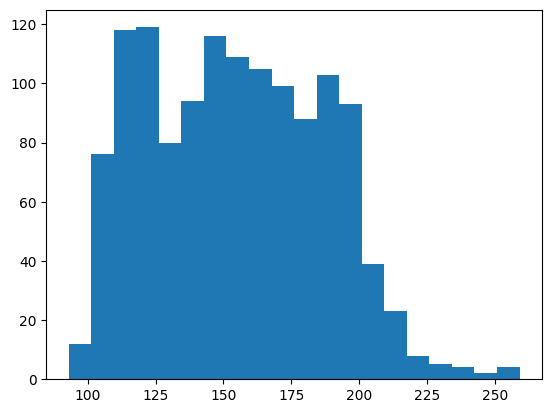

In [71]:
trans_len1 = np.array([trj['obs'].shape[0] for trj in stitch_1])
print(trans_len1)
total_trans = np.sum(trans_len1)
print(f'total_trans: {total_trans}', np.mean(trans_len1), np.min(trans_len1), np.max(trans_len1))
plt.hist(trans_len1, bins=20)

[105 154 113 ... 292 146 220]
total_trans: 272682 164.56366928183465 90 312


(array([  9.,  92., 153., 133., 122., 170., 182., 185., 196., 185., 102.,
         62.,  36.,  17.,   7.,   3.,   1.,   1.,   0.,   1.]),
 array([ 90. , 101.1, 112.2, 123.3, 134.4, 145.5, 156.6, 167.7, 178.8,
        189.9, 201. , 212.1, 223.2, 234.3, 245.4, 256.5, 267.6, 278.7,
        289.8, 300.9, 312. ]),
 <BarContainer object of 20 artists>)

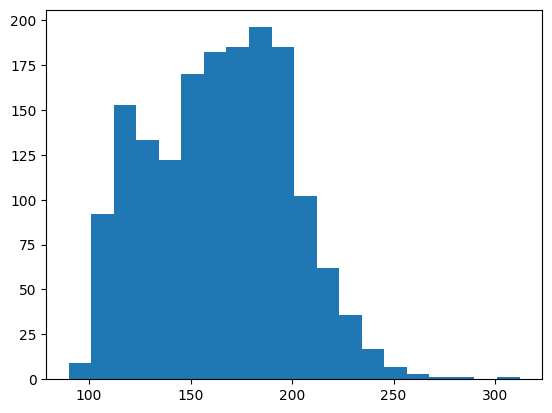

In [257]:
trans_len2 = np.array([trj['obs'].shape[0] for trj in stitch_2])
print(trans_len)
total_trans = np.sum(trans_len2)
print(f'total_trans: {total_trans}', np.mean(trans_len2), np.min(trans_len2), np.max(trans_len2))
plt.hist(trans_len2, bins=20)

[105 154 113 ... 292 146 220]
total_trans: 284499 172.3192004845548 93 294


(array([ 17.,  76., 122.,  97., 100.,  94., 157., 166., 147., 188., 168.,
        107.,  71.,  49.,  36.,  27.,  13.,  11.,   2.,   3.]),
 array([ 93.  , 103.05, 113.1 , 123.15, 133.2 , 143.25, 153.3 , 163.35,
        173.4 , 183.45, 193.5 , 203.55, 213.6 , 223.65, 233.7 , 243.75,
        253.8 , 263.85, 273.9 , 283.95, 294.  ]),
 <BarContainer object of 20 artists>)

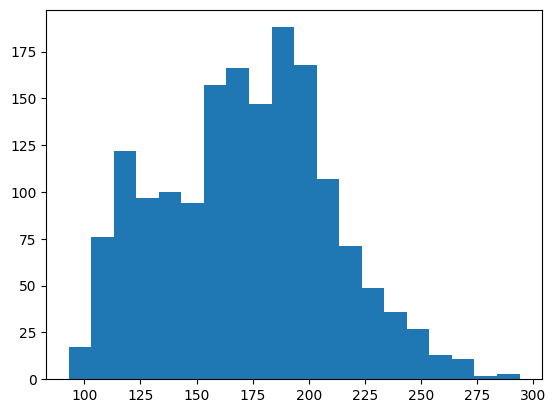

In [219]:
trans_len3 = np.array([trj['obs'].shape[0] for trj in stitch_3])
print(trans_len)
total_trans = np.sum(trans_len3)
print(f'total_trans: {total_trans}', np.mean(trans_len3), np.min(trans_len3), np.max(trans_len3))
plt.hist(trans_len3, bins=20)

In [164]:
stitched_trjs[0].keys()

dict_keys(['obs', 'act', 'rew', 'next_obs', 'dones', 'region_idx'])

In [ ]:
stti

In [64]:
stitch_1_rew = np.array([sum(trj['rew']) for trj in stitch_1])
print(f'stitch1 rew: max: {np.max(stitch_1_rew)}\t mean: {np.mean(stitch_1_rew)}\t min: {np.min(stitch_1_rew)}')

stitch_2_rew = np.array([sum(trj['rew']) for trj in stitch_2])
print(f'stitch1 rew: max: {np.max(stitch_2_rew)}\t mean: {np.mean(stitch_2_rew)}\t min: {np.min(stitch_2_rew)}')

stitch_3_rew = np.array([sum(trj['rew']) for trj in stitch_3])
print(f'stitch1 rew: max: {np.max(stitch_3_rew)}\t mean: {np.mean(stitch_3_rew)}\t min: {np.min(stitch_3_rew)}')

stitch1 rew: max: 2.0	 mean: 0.69236700077101	 min: -1.0
stitch1 rew: max: 2.0	 mean: 0.7006638503319251	 min: -1.0
stitch1 rew: max: 2.0	 mean: 0.7813446396123561	 min: -1.0


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 3., 1., 2., 2.,
        0., 0., 1.]),
 array([106.  , 110.25, 114.5 , 118.75, 123.  , 127.25, 131.5 , 135.75,
        140.  , 144.25, 148.5 , 152.75, 157.  , 161.25, 165.5 , 169.75,
        174.  , 178.25, 182.5 , 186.75, 191.  ]),
 <BarContainer object of 20 artists>)

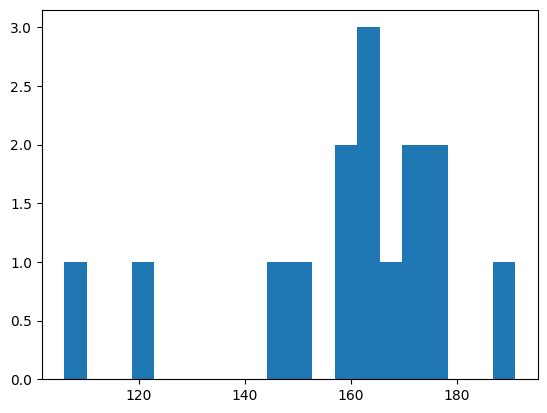

In [230]:
plt.hist(trans_len1[np.where(stitch_1_rew==2)[0]], bins=20)

(array([1., 2., 0., 2., 4., 7., 4., 6., 9., 3., 4., 5., 2., 1., 0., 2., 2.,
        1., 2., 2.]),
 array([116. , 122.4, 128.8, 135.2, 141.6, 148. , 154.4, 160.8, 167.2,
        173.6, 180. , 186.4, 192.8, 199.2, 205.6, 212. , 218.4, 224.8,
        231.2, 237.6, 244. ]),
 <BarContainer object of 20 artists>)

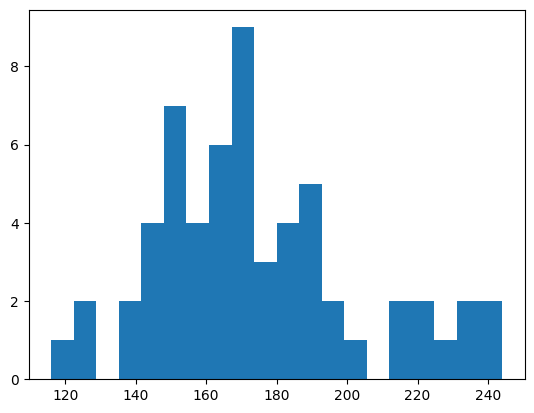

In [229]:
plt.hist(trans_len2[np.where(stitch_2_rew==2)[0]], bins=20)

(array([ 4.,  2.,  3.,  4.,  8.,  9., 21., 15., 22., 17., 13., 14.,  9.,
         3., 10.,  5.,  4.,  0.,  0.,  2.]),
 array([108. , 115.9, 123.8, 131.7, 139.6, 147.5, 155.4, 163.3, 171.2,
        179.1, 187. , 194.9, 202.8, 210.7, 218.6, 226.5, 234.4, 242.3,
        250.2, 258.1, 266. ]),
 <BarContainer object of 20 artists>)

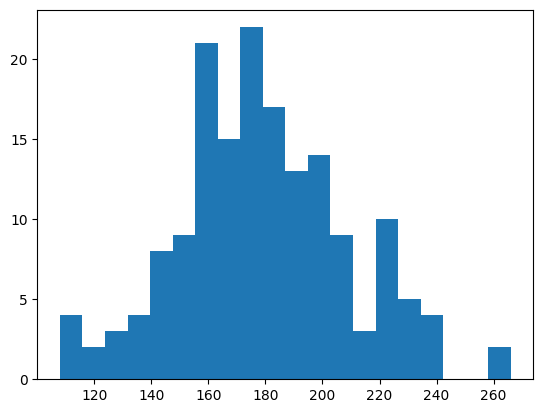

In [228]:
plt.hist(trans_len3[np.where(stitch_3_rew==2)[0]], bins=20)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

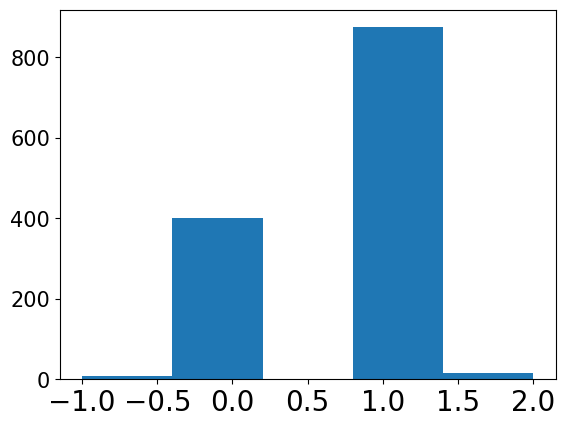

In [65]:
plt.hist(stitch_1_rew, bins=5)
plt.xticks(size = 20)
plt.yticks(size = 15)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

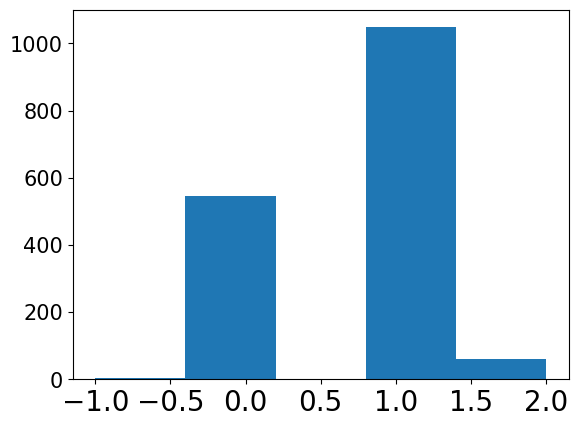

In [40]:
plt.hist(stitch_2_rew, bins=5)
plt.xticks(size = 20)
plt.yticks(size = 15)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

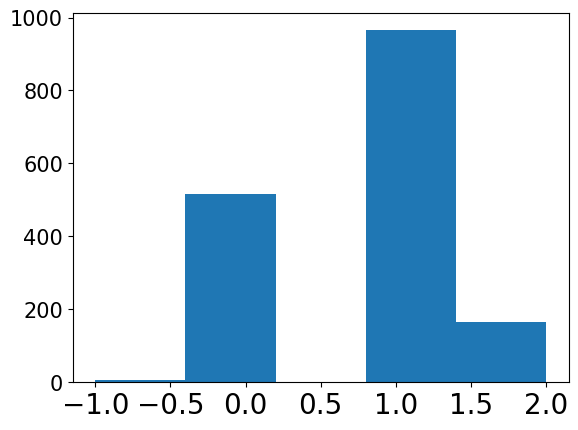

In [41]:
plt.hist(stitch_3_rew, bins=5)
plt.xticks(size = 20)
plt.yticks(size = 15)

In [47]:
def comp_epi_return(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rew']
        
        r_ = 0
        l = len(rewards)
        
        for i in range(l):
            r_ = (discounts[:l-i] * rewards[i:]).sum()
            r.append(r_)
        
    return r

In [48]:
def comp_epi_return_v2(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rew']
        
        r_ = 0
        l = len(rewards)
        r.append((discounts[:l] * rewards).sum())
        
        
    return r

In [59]:
round1_return = np.array(comp_epi_return(stitch_1))
round2_return = np.array(comp_epi_return(stitch_2))
round3_return = np.array(comp_epi_return(stitch_3))
print(f'traj1 return: max: {np.max(round1_return)}\t, mean: {np.mean(round1_return)}\t min: {np.min(round1_return)}')
print(f'traj2 return: max: {np.max(round2_return)}\t, mean: {np.mean(round2_return)}\t min: {np.min(round2_return)}')
print(f'traj3 return: max: {np.max(round3_return)}\t, mean: {np.mean(round3_return)}\t min: {np.min(round3_return)}')

traj1 return: max: 1.5639051904523875	, mean: 0.3337770893115084	 min: -1.0
traj2 return: max: 1.5048858887870695	, mean: 0.31586901793176153	 min: -1.0
traj3 return: max: 1.5526834771623852	, mean: 0.3226555964551641	 min: -1.0


(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

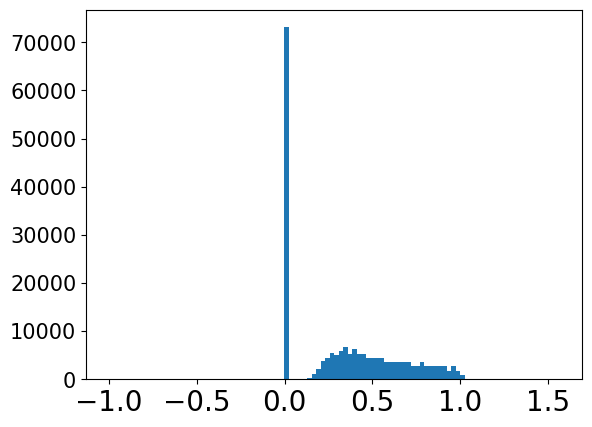

In [47]:
plt.hist(round1_return, bins=100)
plt.xticks(size = 20)
plt.yticks(size = 15)

In [60]:
round1_return_v2 = np.array(comp_epi_return_v2(stitch_1))
round2_return_v2 = np.array(comp_epi_return_v2(stitch_2))
round3_return_v2 = np.array(comp_epi_return_v2(stitch_3))

print(f'traj1 return: max: {np.max(round1_return_v2)}\t, mean: {np.mean(round1_return_v2)}\t min: {np.min(round1_return_v2)}')
print(f'traj2 return: max: {np.max(round2_return_v2)}\t, mean: {np.mean(round2_return_v2)}\t min: {np.min(round2_return_v2)}')
print(f'traj3 return: max: {np.max(round3_return_v2)}\t, mean: {np.mean(round3_return_v2)}\t min: {np.min(round3_return_v2)}')

traj1 return: max: 0.9653832554347299	, mean: 0.17785128860740942	 min: -0.2127257032290187
traj2 return: max: 0.9383345680721519	, mean: 0.18268505484739556	 min: -0.1848045639485463
traj3 return: max: 0.9584562024563302	, mean: 0.2276233287698436	 min: -0.19629151402302525


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

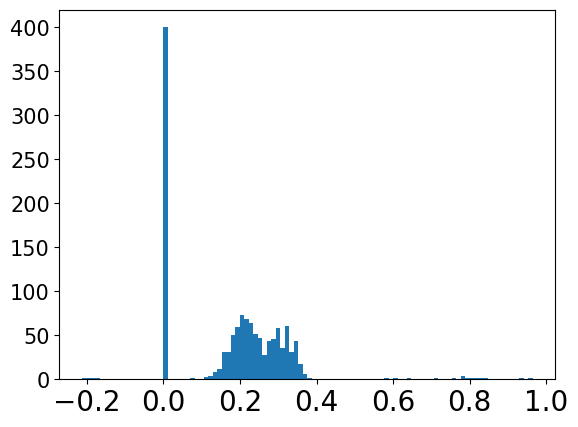

In [50]:
plt.hist(round1_return_v2, bins=100)
plt.xticks(size = 20)
plt.yticks(size = 15)

In [51]:
discounts = 0.99 ** np.arange(1000)
discounts[:180]

array([1.        , 0.99      , 0.9801    , 0.970299  , 0.96059601,
       0.95099005, 0.94148015, 0.93206535, 0.92274469, 0.91351725,
       0.90438208, 0.89533825, 0.88638487, 0.87752102, 0.86874581,
       0.86005835, 0.85145777, 0.84294319, 0.83451376, 0.82616862,
       0.81790694, 0.80972787, 0.80163059, 0.79361428, 0.78567814,
       0.77782136, 0.77004315, 0.76234271, 0.75471929, 0.74717209,
       0.73970037, 0.73230337, 0.72498034, 0.71773053, 0.71055323,
       0.70344769, 0.69641322, 0.68944909, 0.6825546 , 0.67572905,
       0.66897176, 0.66228204, 0.65565922, 0.64910263, 0.6426116 ,
       0.63618549, 0.62982363, 0.62352539, 0.61729014, 0.61111724,
       0.60500607, 0.59895601, 0.59296645, 0.58703678, 0.58116641,
       0.57535475, 0.5696012 , 0.56390519, 0.55826614, 0.55268348,
       0.54715664, 0.54168508, 0.53626823, 0.53090554, 0.52559649,
       0.52034052, 0.51513712, 0.50998575, 0.50488589, 0.49983703,
       0.49483866, 0.48989027, 0.48499137, 0.48014146, 0.47534

In [77]:
return_zero_idx = np.where(round1_return_v2 == 0.0)[0]

In [79]:
return_zero_idx[:10]

array([ 3,  4,  7,  8, 15, 16, 19, 20, 22, 24])

In [73]:
region_idx = np.array([trj['region_idx'] for trj in stitch_1])

In [75]:
stitch_1[0].keys()

dict_keys(['obs', 'act', 'rew', 'next_obs', 'dones', 'region_idx'])

In [88]:
traj2_idx = aug_list_1[3][2]

In [89]:
trj2 = env_dataset.get_full_info_traj(traj2_idx)

In [107]:
short_trj_reward = np.array([sum(seq['rew']) for seq in env_dataset.paths])

(array([2.000e+00, 0.000e+00, 6.750e+02, 0.000e+00, 0.000e+00, 1.413e+03,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <BarContainer object of 10 artists>)

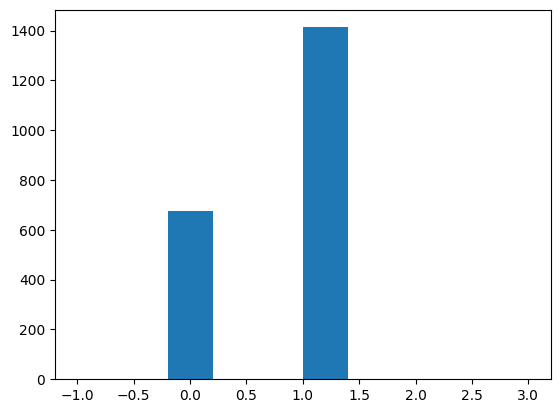

In [108]:
plt.hist(short_trj_reward)

In [104]:
len(env_dataset.paths)

1483

In [97]:
(short_trj_reward == 0).sum()

675

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

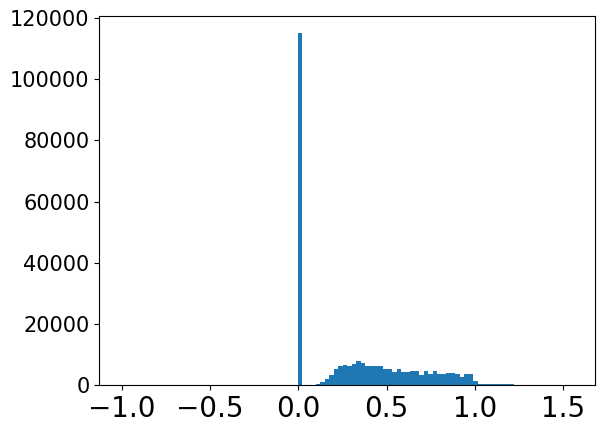

In [47]:
plt.hist(round3_return, bins=100)
plt.xticks(size = 20)
plt.yticks(size = 15)

In [106]:
region_idx = [l['region_idx'][0] for l in stitched_trjs]
region_idx_map = defaultdict(int)
for r_idx in region_idx:
    region_idx_map[r_idx] += 1
region_idx_map

defaultdict(int,
            {69: 7,
             68: 2,
             28: 5,
             43: 3,
             73: 4,
             57: 10,
             92: 5,
             25: 4,
             74: 4,
             54: 10,
             7: 6,
             10: 11,
             80: 9,
             53: 2,
             4: 5,
             15: 8,
             98: 2,
             84: 5,
             95: 2,
             18: 2,
             20: 3,
             65: 2,
             90: 3,
             91: 10,
             3: 1,
             96: 1,
             87: 1,
             61: 2})

In [111]:
class StitchBuffer:
    def __init__(self, horizon, ratio=0.1, gamma=0.99):
        self.gamma = gamma
        self.ratio = ratio
        self.info = []
        self.horizon = horizon
        self.region_map = defaultdict(list)
        self.count = 0
        self.returns_list = []

    def insert_traj(self, info):
        current_total_reward = 0
        current_discounted_reward = 0
        for i in range(info["horizon"] - 1, -1, -1):
            current_total_reward += info["rew"][i]
            current_discounted_reward = (
                current_discounted_reward * self.gamma + info["rew"][i]
            )
            if info["horizon"] - i >= self.horizon:
                current_info = {
                    "discounted_reward": current_discounted_reward,
                    "obs": info["obs"][i : i + self.horizon],
                    "segment_idx": i,
                    "region_idx": info["region_idx"][i : i + self.horizon],
                    "traj_idx": info["trajectory_idx"],
                    'rew': info['rew'][i:i+self.horizon],
                }
                self.info.append(current_info)
                self.region_map[info["region_idx"][0]].append(self.count)
                self.count += 1
                self.returns_list.append(sum(info['rew']))
        
    def finalize(self, ):
        self.returns_list = np.array(self.returns_list)
        self.returns_list -= self.returns_list.min()
    
    def sample_batch_traj(self, optim_batch, dataset, region_avoid):
        # stored in (d-rtg, obs:(100, obs_dim))

        sample_idx = []
        for k in self.region_map:
            if k not in region_avoid:
                sample_idx += self.region_map[k]

        sample_p = self.returns_list[np.array(sample_idx)]
        sample_p = sample_p / sample_p.sum()
        
        batch_info = []
        batch_index = np.random.choice(sample_idx, size=optim_batch, replace=False, p=sample_p)
        batch_info = [self.info[_] for _ in batch_index]

        return batch_info

In [112]:
stitch_dataset = StitchDataset(stitched_trjs)
stitch_buffer  = StitchBuffer(horizon=Config.horizon)
for i in range(stitch_dataset.num_traj): 
    info = stitch_dataset.get_full_info_traj(i)  
    stitch_buffer.insert_traj(info)
stitch_buffer.finalize()

processed 129 trajectories


In [55]:
len(stitch_buffer.info)

1866

In [24]:
horizon = Config.horizon
device = Config.device
dynamics_deviate = 0.15
test_ret = 0.85
sample_optim_batch = 1000
dreamer_similarity = 0.95
stitch_L = 10
stitch_R = 30
# obs_dim = observation_dim
dream_len = Config.dream_len
stitch_batch_size = 1000

In [114]:
aug_list_round2 = []
timer = Timer()
timer_2 = Timer()
generated_transitions = 0
while generated_transitions < 10000:
    
    trj1_info = stitch_buffer.sample_batch_traj(stitch_batch_size, env_dataset, [])
    
    trj1_obs = np.stack([info['obs'] for info in trj1_info], axis=0)
    trj1_normed_obs = dataset.normalizer.normalize(trj1_obs, 'observations')

    # conditional generation from the end of trj1
    cond = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    conditions = get_conditions(cond, dream_len, trj1_normed_obs, device)
    returns = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)

    samples = trainer.ema_model.conditional_sample(
        conditions, returns=returns, verbose=False
    )  # shape is [N, 100, 11]
    normed_gen_obs = to_np(samples)
    gen_obs = dataset.normalizer.unnormalize(normed_gen_obs, 'observations')
    

    cond_p = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    mark_succ = np.zeros(shape=(stitch_batch_size,))
    positions = []
    for i in range(0, stitch_batch_size):
        region_idx1 = trj1_info[i]['region_idx'][0]
        region_idx11 = region_idx1 // 10
        region_idx12 = region_idx1 % 10
        
        # sample a batch of optimal trajectories
        available_positions = []
        n_try = 0
        while len(available_positions) == 0:
            candidates_trj2_info = data_buffer.sample_batch_traj(
                sample_optim_batch, dataset, [region_idx11, region_idx12])
            
            candidates_trj2_obs = np.stack([info['obs'] for info in candidates_trj2_info], axis=0)
            
            # (stitch_L - stitch_R) x sample_optim_batch
            cosin_sim = cosine_similarity(gen_obs[i, stitch_L:stitch_R,], candidates_trj2_obs[:, 0,])
            # see which trajectory has a similarity greater than threshold
            for cur_pos in range(stitch_L, stitch_R):
                
                cur_sim = cosin_sim[cur_pos-stitch_L]
            
                if np.max(cur_sim) < dreamer_similarity:
                    continue
                temp_pos = list(np.where(cur_sim >= dreamer_similarity)[0])
                for pos in temp_pos:
                    available_positions.append(pos)
            n_try += 1
            if n_try >  3:
                break

        
        if len(available_positions) == 0:
            # pdb.set_trace()
            positions.append([0, 0])
            continue
            
        available_positions = list(set(available_positions))
        
        mark_succ[i] = 1
        chosen_index = random.randint(0, len(available_positions) - 1)

        trj2_info = candidates_trj2_info[available_positions[chosen_index]]
        
        traj2_obs = trj2_info["obs"]
        traj2_normed_obs = dataset.normalizer.normalize(traj2_obs, "observations")
        traj2_idx = candidates_trj2_info[available_positions[chosen_index]]['traj_idx']
        traj2_start_idx = candidates_trj2_info[available_positions[chosen_index]]['segment_idx']
        region_idx2 = candidates_trj2_info[available_positions[chosen_index]]['region_idx'][0]
        
        # (stitch_L - stitch_R) x 1
        dist_i = cosin_sim[:,available_positions[chosen_index]]
        best_pos = np.argmax(dist_i, axis=0) + stitch_L
        
        start_index = dream_len
        end_index = best_pos - 1
        positions.append([start_index, end_index, traj2_idx, traj2_start_idx, region_idx11, region_idx12, region_idx2])
        cond_p[i][:, obs_dim:] = 0
        cond_p[i][:start_index, :obs_dim] = 0
        cond_p[i][:start_index, obs_dim:] = trj1_normed_obs[i][-start_index:]
        cond_p[i][end_index + 1 :, :obs_dim] = 0
        cond_p[i][end_index + 1 :, obs_dim:] = traj2_normed_obs[: horizon - best_pos]

    conditions_p = torch.tensor(cond_p).to(device)
    returns_p = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    samples_p = trainer.ema_model.conditional_sample(
        conditions_p, returns=returns_p, verbose=False
    )  # shape is [64, 100, 11]
    np_samples_p = to_np(samples_p)
    obss_p = dataset.normalizer.unnormalize(np_samples_p, "observations")
    
    traj2_time = timer_2.mean()
    print(f'traj2 preparation time: {traj2_time:.2f}')
    
    succ_cnt = 0
    print(f' number of candidate trj1: {sum(mark_succ)}')
    if sum(mark_succ) == 0:
        print(f'no trj2 found')
        continue
    # pdb.set_trace()
        
    
    total_number_traj = sum(mark_succ)
    filtered_number_traj = 0
    
    for j in range(0, stitch_batch_size):
    
        # failed to reach threshold
        if mark_succ[j] != 1:
            # print(f'{j}th sample no stitching')
            continue
        end_index = positions[j][1]
        start_index = positions[j][0]
        traj2_idx = positions[j][2]
        traj2_start_idx = positions[j][3]
        region_idx11 = positions[j][4]
        region_idx12 = positions[j][5]
        region_idx2 = positions[j][6]

        move = np.linalg.norm(obss_p[j][:-1,:2] - obss_p[j][1:,:2], axis=-1)
        if (move > dynamics_deviate).any():
            jump = move.max()
            filtered_number_traj += 1
            print(f'found jumps {jump:.3f} in {j}th stitching')
            continue
        
        best_pos = end_index + 1
        len_path_data = end_index - start_index + 2
        return_info = {}
        return_info["act"] = np.zeros(shape=(len_path_data, action_dim))
        return_info["rew"] = np.zeros(shape=(len_path_data))
        return_info["obs"] = np.zeros(shape=(len_path_data + 1, obs_dim))
        

        obs_comb = torch.cat(
                [samples_p[j, start_index - 1:end_index+1, :], samples_p[j, start_index:end_index+2, :]], dim=-1)
        obs_comb = obs_comb.reshape(-1, 2 * obs_dim)
        action_ = trainer.ema_model.inv_model(obs_comb)  # [1,3]
        normed_actions = to_np(action_)
        actions = dataset.normalizer.unnormalize(normed_actions, 'actions')
        
        dynamics_info = dynamics_model.predict(obss_p[j, start_index-1:end_index+1], actions)
        pred_obs = dynamics_info['next_obs']
        pred_rew = dynamics_info['reward']

        pred_deviate = np.linalg.norm(pred_obs - obss_p[j, start_index:end_index+2], axis=-1)
        if (pred_deviate > dynamics_deviate).any():
            filtered_number_traj += 1
            deviate = pred_deviate.max()
            print(f'dynamics: {j}th filtered deviate {deviate:.3f}')
            continue

        succ_cnt += 1
        return_info["obs"] = obss_p[j][start_index - 1 : end_index + 2]
    
        aug_cnt = return_info["rew"].shape[0]
    
        return_info["next_obs"] = return_info["obs"][1:]
        return_info["obs"] = return_info["obs"][:-1]
        return_info["dones"] = np.full((aug_cnt,), False, dtype=bool)
        return_info['region_idx'] = np.ones((aug_cnt,), dtype=np.int8) * int(str(region_idx11)+str(region_idx12)+str(region_idx2))
    
        for _ in ["obs", "rew", "dones", "next_obs", "act"]:
            return_info[_] = return_info[_][:]
    
        generated_transitions = generated_transitions + return_info["obs"].shape[0] + 2 * horizon
        if succ_cnt % 1 == 0:
            clapsed = timer() / generated_transitions * 1000
            
            print(f' =========  processed {generated_transitions} transitions,\t clapsed per 1k transition {clapsed:.2f} sec.  =========')
            
        aug_list_round2.append(
            (
                trj1_info[j]['traj_idx'],
                trj1_info[j]['segment_idx'],
                traj2_idx,
                traj2_start_idx,
                start_index,
                end_index,
                obss_p[j],
                return_info["obs"],
                return_info["act"],
                return_info["rew"],
                return_info["next_obs"],
                return_info["dones"],
                return_info['region_idx']
            )
        )

traj2 preparation time: 36.30
 number of candidate trj1: 999.0
found jumps 0.163 in 0th stitching
dynamics: 1th filtered deviate 0.329
dynamics: 2th filtered deviate 1.250
dynamics: 3th filtered deviate 0.851
found jumps 0.265 in 4th stitching
dynamics: 5th filtered deviate 0.694
found jumps 0.188 in 6th stitching
found jumps 2.174 in 7th stitching
dynamics: 8th filtered deviate 0.392
dynamics: 9th filtered deviate 0.689
dynamics: 10th filtered deviate 0.684
dynamics: 11th filtered deviate 0.911
dynamics: 12th filtered deviate 0.674
dynamics: 13th filtered deviate 0.790
found jumps 0.271 in 14th stitching
dynamics: 15th filtered deviate 0.767
found jumps 1.119 in 16th stitching
found jumps 0.546 in 17th stitching
found jumps 0.250 in 18th stitching
dynamics: 19th filtered deviate 0.769
dynamics: 20th filtered deviate 0.460
dynamics: 21th filtered deviate 0.946
dynamics: 22th filtered deviate 0.491
found jumps 0.935 in 23th stitching
dynamics: 24th filtered deviate 0.253
found jumps 0.8

In [115]:
stitched_trjs = []
for i in range(len(aug_list_round2)):
    
    stitch_trj = dict(
        obs = aug_list_round2[i][7][1:],
        act = aug_list_round2[i][8][1:],
        rew = aug_list_round2[i][9][1:],
        next_obs = aug_list_round2[i][10][1:],
        dones = aug_list_round2[i][11][1:],
        region_idx = aug_list_round2[i][12][1:],
    )# the fisrt state in stitch_trj is the last state in trj1

    traj2_idx = aug_list_round2[i][2]
    traj2_segment_idx = aug_list_round2[i][3]
    trj2 = env_dataset.get_full_info_traj(traj2_idx)
    for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
        trj2[k] = trj2[k][traj2_segment_idx:]

    traj1_idx = aug_list_round2[i][0]
    traj1_segment_idx = aug_list_round2[i][1]
    trj1 = stitch_dataset.get_full_info_traj(traj1_idx)
    for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
        trj1[k] = trj1[k][:traj1_segment_idx+horizon] 

    new_trj = process_stitched_trajectories(trj1, stitch_trj, trj2)
    stitched_trjs.append(new_trj)

In [116]:
avg_len = np.mean([trj['obs'].shape[0] for trj in stitched_trjs])
print(f'avg_len: {avg_len}')

avg_len: 170.07758620689654


In [117]:
region_idx = [l['region_idx'][0] for l in stitched_trjs]
region_idx_map = defaultdict(int)
for r_idx in region_idx:
    region_idx_map[r_idx] += 1
region_idx_map

defaultdict(int,
            {547: 3,
             159: 1,
             915: 4,
             201: 1,
             692: 4,
             189: 2,
             43: 6,
             185: 1,
             74: 1,
             807: 4,
             285: 4,
             843: 1,
             107: 4,
             281: 1,
             540: 5,
             928: 1,
             108: 1,
             543: 2,
             251: 1,
             921: 3,
             695: 1,
             105: 2,
             804: 2,
             574: 3,
             685: 1,
             37: 1,
             612: 1,
             698: 2,
             924: 1,
             73: 2,
             906: 1,
             803: 5,
             958: 2,
             910: 1,
             950: 1,
             104: 3,
             75: 2,
             150: 5,
             153: 1,
             209: 1,
             289: 1,
             689: 1,
             918: 2,
             912: 1,
             916: 1,
             47: 2,
             907: 1,
  

In [118]:
np.array([sum(trj['rew']) for trj in stitched_trjs])

array([ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  0.,  1.,  2.,  2.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
        0.,  1.,  0.,  1.,  2.,  0., -1.,  1.,  0.,  1.,  0.,  1.])

In [123]:
with open('./round1_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    stitched_data = pickle.load(f)

In [124]:
stitched_trjs = []
for i in range(len(stitched_data)):
    
    stitch_trj = dict(
        obs = stitched_data[i][7][1:],
        act = stitched_data[i][8][1:],
        rew = stitched_data[i][9][1:],
        next_obs = stitched_data[i][10][1:],
        dones = stitched_data[i][11][1:],
        region_idx = stitched_data[i][12],
    )

    traj2_idx = stitched_data[i][2]
    traj2_segment_idx = stitched_data[i][3]
    trj2 = env_dataset.get_full_info_traj(traj2_idx)
    for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
        trj2[k] = trj2[k][traj2_segment_idx:]

    traj1_idx = stitched_data[i][0]
    traj1_segment_idx = stitched_data[i][1]
    trj1 = stitch_dataset.get_full_info_traj(traj1_idx)
    for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
        trj1[k] = trj1[k][:traj1_segment_idx+horizon-1] # the last state in trj1 is the first state in stitch_trj

    new_trj = process_stitched_trajectories(trj1, stitch_trj, trj2)
    stitched_trjs.append(new_trj)

IndexError: list index out of range

## No clustering stitching

In [21]:
with open('./trim_final_task/round1_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_1 = pickle.load(f)

with open('./trim_final_task/round2_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_2 = pickle.load(f)

with open('./trim_final_task/round3_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_3 = pickle.load(f)

In [25]:
stitch_1 = read_stitched_data(aug_list_1, env_dataset)
stitch_1_dataset = StitchDataset(stitch_1)
stitch_2 = read_stitched_data(aug_list_2, stitch_1_dataset)
stitch_2_dataset = StitchDataset(stitch_2)
stitch_3 = read_stitched_data(aug_list_3, stitch_2_dataset)

processed 958 trajectories
processed 1117 trajectories


In [31]:
post_processed_stitch1 = post_process_stitched_trjs(stitch_1)
post_processed_stitch2 = post_process_stitched_trjs(stitch_2)
post_processed_stitch3 = post_process_stitched_trjs(stitch_3)

In [167]:
for k in post_processed_stitch1:
    print(f'{k} shape: {post_processed_stitch1[k].shape}')

actions shape: (138056, 9)
observations shape: (138056, 30)
terminals shape: (138056,)
rewards shape: (138056,)


In [168]:
for k in post_processed_stitch2:
    print(f'{k} shape: {post_processed_stitch2[k].shape}')

actions shape: (194507, 9)
observations shape: (194507, 30)
terminals shape: (194507,)
rewards shape: (194507,)


In [169]:
for k in post_processed_stitch3:
    print(f'{k} shape: {post_processed_stitch3[k].shape}')

actions shape: (201006, 9)
observations shape: (201006, 30)
terminals shape: (201006,)
rewards shape: (201006,)


total_trans: 138056 144.10855949895617 97 226


(array([  9.,  53., 104.,  81.,  72.,  53.,  70.,  80.,  89., 103.,  76.,
         74.,  40.,  22.,  11.,  11.,   2.,   4.,   0.,   4.]),
 array([ 97.  , 103.45, 109.9 , 116.35, 122.8 , 129.25, 135.7 , 142.15,
        148.6 , 155.05, 161.5 , 167.95, 174.4 , 180.85, 187.3 , 193.75,
        200.2 , 206.65, 213.1 , 219.55, 226.  ]),
 <BarContainer object of 20 artists>)

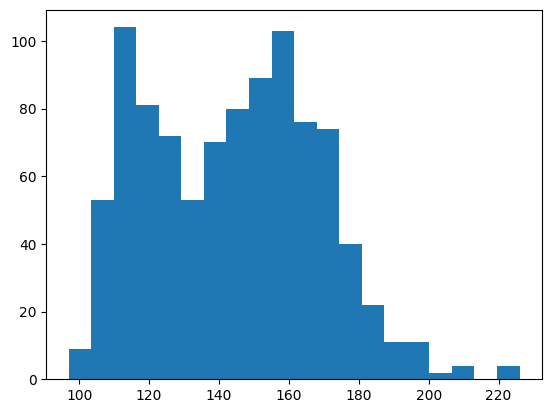

In [33]:
trans_len1 = np.array([trj['obs'].shape[0] for trj in stitch_1])

total_trans = np.sum(trans_len1)
print(f'total_trans: {total_trans}', np.mean(trans_len1), np.min(trans_len1), np.max(trans_len1))
plt.hist(trans_len1, bins=20)

total_trans: 194507 174.13339301700984 98 264


(array([  4.,  18.,  42.,  39.,  31.,  49., 114., 178., 137.,  96.,  64.,
         57.,  71.,  76.,  55.,  53.,  22.,   7.,   2.,   2.]),
 array([ 98. , 106.3, 114.6, 122.9, 131.2, 139.5, 147.8, 156.1, 164.4,
        172.7, 181. , 189.3, 197.6, 205.9, 214.2, 222.5, 230.8, 239.1,
        247.4, 255.7, 264. ]),
 <BarContainer object of 20 artists>)

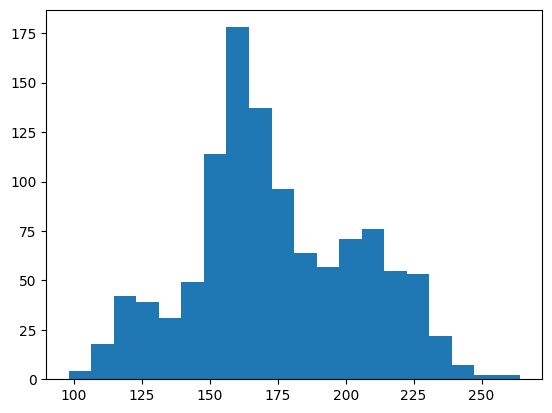

In [34]:
trans_len2 = np.array([trj['obs'].shape[0] for trj in stitch_2])
total_trans = np.sum(trans_len2)
print(f'total_trans: {total_trans}', np.mean(trans_len2), np.min(trans_len2), np.max(trans_len2))
plt.hist(trans_len2, bins=20)

total_trans: 201006 180.27443946188342 105 289


(array([ 21.,  30.,  29.,  19.,  48., 150., 187., 126.,  87.,  60.,  92.,
         86.,  77.,  50.,  26.,  10.,  13.,   2.,   1.,   1.]),
 array([105. , 114.2, 123.4, 132.6, 141.8, 151. , 160.2, 169.4, 178.6,
        187.8, 197. , 206.2, 215.4, 224.6, 233.8, 243. , 252.2, 261.4,
        270.6, 279.8, 289. ]),
 <BarContainer object of 20 artists>)

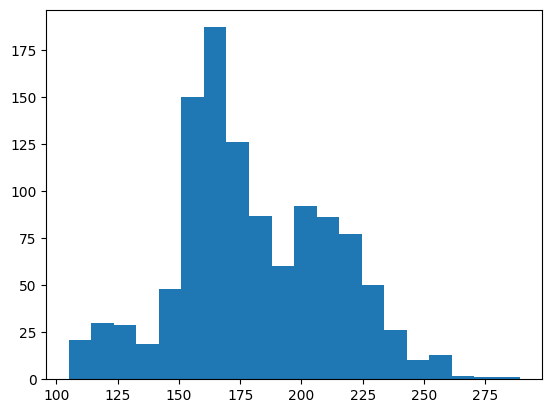

In [35]:
trans_len3 = np.array([trj['obs'].shape[0] for trj in stitch_3])
total_trans = np.sum(trans_len3)
print(f'total_trans: {total_trans}', np.mean(trans_len3), np.min(trans_len3), np.max(trans_len3))
plt.hist(trans_len3, bins=20)

In [36]:
stitch_1_rew = np.array([sum(trj['rew']) for trj in stitch_1])
print(f'stitch1 rew: max: {np.max(stitch_1_rew)}\t mean: {np.mean(stitch_1_rew)}\t min: {np.min(stitch_1_rew)}')

stitch_2_rew = np.array([sum(trj['rew']) for trj in stitch_2])
print(f'stitch1 rew: max: {np.max(stitch_2_rew)}\t mean: {np.mean(stitch_2_rew)}\t min: {np.min(stitch_2_rew)}')

stitch_3_rew = np.array([sum(trj['rew']) for trj in stitch_3])
print(f'stitch1 rew: max: {np.max(stitch_3_rew)}\t mean: {np.mean(stitch_3_rew)}\t min: {np.min(stitch_3_rew)}')

stitch1 rew: max: 2.0	 mean: 1.0093945720250521	 min: 1.0
stitch1 rew: max: 2.0	 mean: 1.9230080572963295	 min: 0.0
stitch1 rew: max: 2.0	 mean: 1.9713004484304932	 min: 1.0


(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1., 1., 0., 0., 0.,
        0., 1., 1.]),
 array([111.  , 114.95, 118.9 , 122.85, 126.8 , 130.75, 134.7 , 138.65,
        142.6 , 146.55, 150.5 , 154.45, 158.4 , 162.35, 166.3 , 170.25,
        174.2 , 178.15, 182.1 , 186.05, 190.  ]),
 <BarContainer object of 20 artists>)

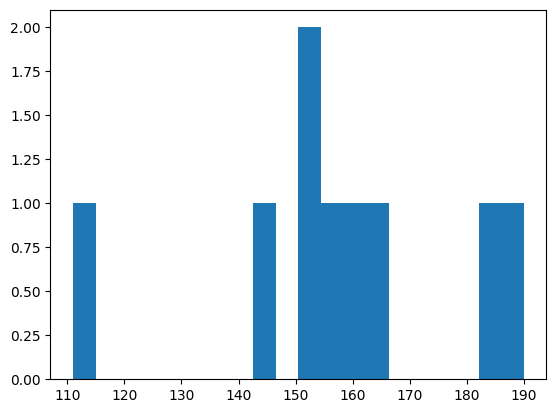

In [174]:
plt.hist(trans_len1[np.where(stitch_1_rew==2)[0]], bins=20)

(array([ 14.,  27.,  22.,  18.,  36.,  69., 145., 154., 119.,  46.,  60.,
         59.,  78.,  62.,  51.,  46.,  17.,   6.,   1.,   2.]),
 array([106. , 113.9, 121.8, 129.7, 137.6, 145.5, 153.4, 161.3, 169.2,
        177.1, 185. , 192.9, 200.8, 208.7, 216.6, 224.5, 232.4, 240.3,
        248.2, 256.1, 264. ]),
 <BarContainer object of 20 artists>)

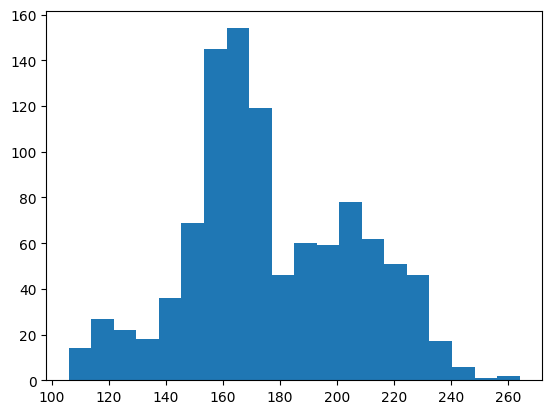

In [175]:
plt.hist(trans_len2[np.where(stitch_2_rew==2)[0]], bins=20)

(array([ 20.,  28.,  25.,  15.,  45., 143., 181., 126.,  86.,  58.,  91.,
         85.,  77.,  50.,  26.,  10.,  13.,   2.,   1.,   1.]),
 array([105. , 114.2, 123.4, 132.6, 141.8, 151. , 160.2, 169.4, 178.6,
        187.8, 197. , 206.2, 215.4, 224.6, 233.8, 243. , 252.2, 261.4,
        270.6, 279.8, 289. ]),
 <BarContainer object of 20 artists>)

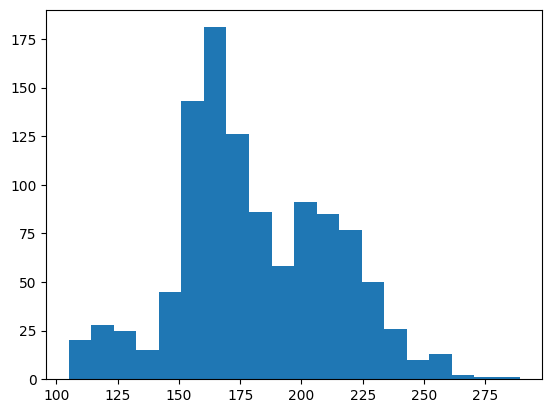

In [176]:
plt.hist(trans_len3[np.where(stitch_3_rew==2)[0]], bins=20)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

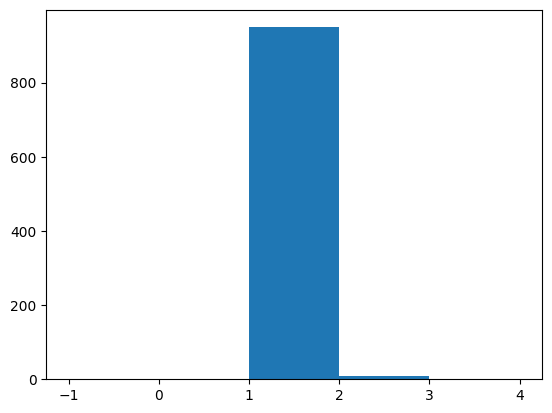

In [43]:
plt.hist(stitch_1_rew, bins=[-1,0,1,2,3,4])
plt.xticks(size = 10)
plt.yticks(size = 10)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

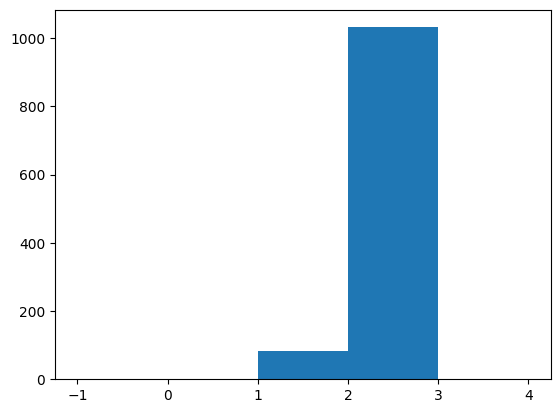

In [42]:
plt.hist(stitch_2_rew, bins=[-1,0,1,2,3,4])
plt.xticks(size = 10)
plt.yticks(size = 10)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

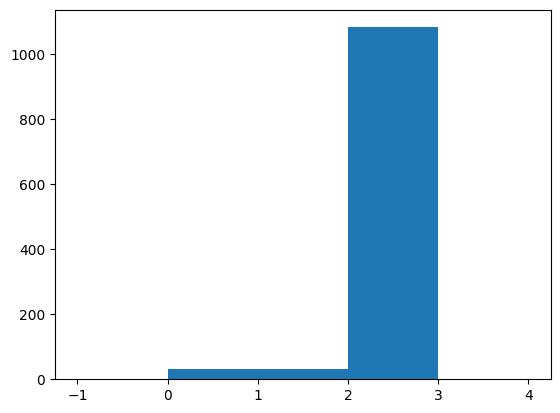

In [45]:
plt.hist(stitch_3_rew, bins=[-1,0,2,3,4])
plt.xticks(size = 10)
plt.yticks(size = 10)

In [52]:
round1_return = np.array(comp_epi_return(stitch_1))
round2_return = np.array(comp_epi_return(stitch_2))
round3_return = np.array(comp_epi_return(stitch_3))

print(f'traj1 return: max: {np.max(round1_return)}\t, mean: {np.mean(round1_return)}\t min: {np.min(round1_return)}')
print(f'traj2 return: max: {np.max(round2_return)}\t, mean: {np.mean(round2_return)}\t min: {np.min(round2_return)}')
print(f'traj3 return: max: {np.max(round3_return)}\t, mean: {np.mean(round3_return)}\t min: {np.min(round3_return)}')

traj1 return: max: 1.5753547499769285	, mean: 0.5289331949095034	 min: 0.10421225282987544
traj2 return: max: 1.5929664464014994	, mean: 0.681313556138602	 min: -0.3242709509397169
traj3 return: max: 1.5753547499769285	, mean: 0.6721664494257353	 min: -0.2750196640421465


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

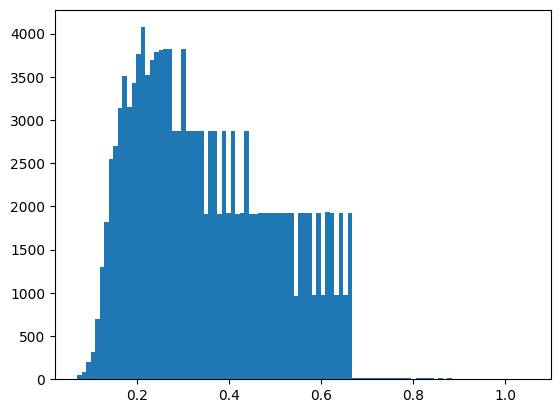

In [53]:
plt.hist(round1_return/1.5, bins=100)
plt.xticks(size = 10)
plt.yticks(size = 10)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

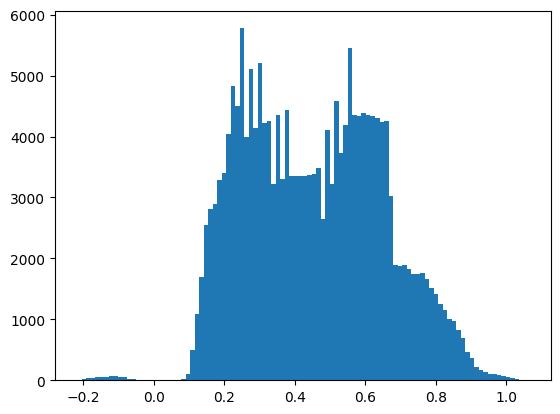

In [54]:
plt.hist(round2_return/1.5, bins=100)
plt.xticks(size = 10)
plt.yticks(size = 10)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

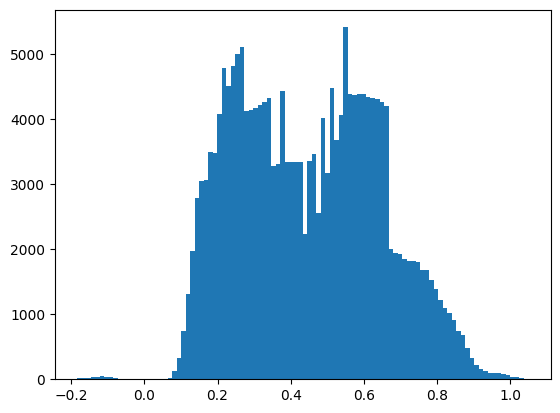

In [55]:
plt.hist(round3_return/1.5, bins=100)
plt.xticks(size = 10)
plt.yticks(size = 10)

In [184]:
file1_name = './round1_stitch_kitchen_partial_H40-v3.pkl'
file2_name = './round2_stitch_kitchen_partial_H40-v3.pkl'
file3_name = './round3_stitch_kitchen_partial_H40-v3.pkl'

In [185]:
with open(file1_name, 'wb') as f:
    pickle.dump(post_processed_stitch1, f)

with open(file2_name, 'wb') as f:
    pickle.dump(post_processed_stitch2, f)

with open(file3_name, 'wb') as f:
    pickle.dump(post_processed_stitch3, f)